In [22]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from igraph import *

In [2]:
data = pd.read_csv("FAOSTAT_data.csv")

In [3]:
data.head()

,Domain Code,Domain,Reporter Country Code (FAO),Reporter Countries,Partner Country Code (FAO),Partner Countries,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,FT,Forestry Trade Flows,2,Afghanistan,68,France,5922,Export Value,1633,"Sawnwood, non-coniferous all",2017,2017,1000 US$,37,NaN,Official data
1,FT,Forestry Trade Flows,2,Afghanistan,165,Pakistan,5922,Export Value,1671,Newsprint,2017,2017,1000 US$,2,NaN,Official data
2,FT,Forestry Trade Flows,3,Albania,11,Austria,5922,Export Value,1633,"Sawnwood, non-coniferous all",2017,2017,1000 US$,29,NaN,Official data
3,FT,Forestry Trade Flows,3,Albania,33,Canada,5922,Export Value,1619,Wood chips and particles,2017,2017,1000 US$,0,NaN,Official data
4,FT,Forestry Trade Flows,3,Albania,68,France,5922,Export Value,1632,"Sawnwood, coniferous",2017,2017,1000 US$,13,NaN,Official data


In [4]:
# remove non-empty values in Flag column
data = data[data["Flag"].isna()]

In [5]:
# is the unit the same?
data["Unit"].unique()

array(['1000 US$'], dtype=object)

## 1.

In [6]:
def create_export_graph(graph_df):
    G_2017 = Graph(directed=True)

    # create nodes
    countries = graph_df["Reporter Countries"].tolist() + graph_df["Partner Countries"].tolist()
    countries = set(countries)
    G_2017.add_vertices(countries)
    G_2017.vs['label'] = list(countries)
    countries_dict = {}
    for i, c in enumerate(countries):
        countries_dict[c] = i

    # create vertices
    edges = []
    weights = []
    for _, row in graph_df.iterrows():
        edges.append((countries_dict[row["Reporter Countries"]], countries_dict[row["Partner Countries"]]))
        weights.append(row["Value"])

    G_2017.add_edges(edges)
    G_2017.es['weight'] = weights
    G_2017.es['label'] = weights
    
    return G_2017

In [65]:
selected_countries = ["China", "France", "Netherlands", "Germany", "Brazil"]

small_data = data[data["Reporter Countries"].isin(selected_countries)]
small_data = small_data[small_data["Partner Countries"].isin(selected_countries)]

graph_df = small_data[["Reporter Countries", "Partner Countries", "Value"]].groupby(["Reporter Countries", "Partner Countries"]).sum().reset_index()
G_2017 = create_export_graph(graph_df)

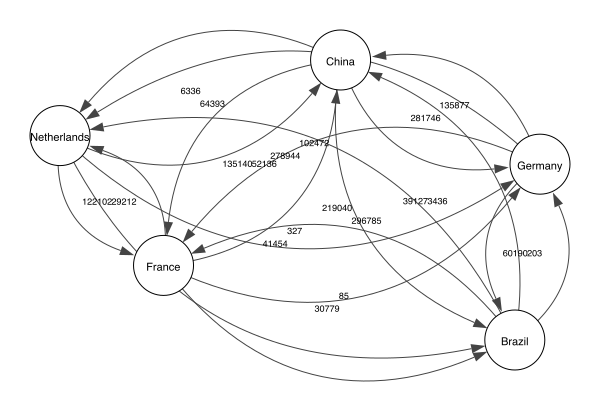

In [67]:
visual_style = {}

out_name = "graph_1.png"

visual_style["bbox"] = (600,400)
visual_style["margin"] = 60
visual_style["vertex_color"] = 'white'
visual_style["vertex_size"] = 60
visual_style["vertex_label_size"] = 11
visual_style["edge_label_size"] = 9
visual_style["edge_curved"] = True
my_layout = G_2017.layout_lgl()
visual_style["layout"] = my_layout
plot(G_2017, out_name, **visual_style)

looks pretty bad, so we decided to use networkx for visualization...

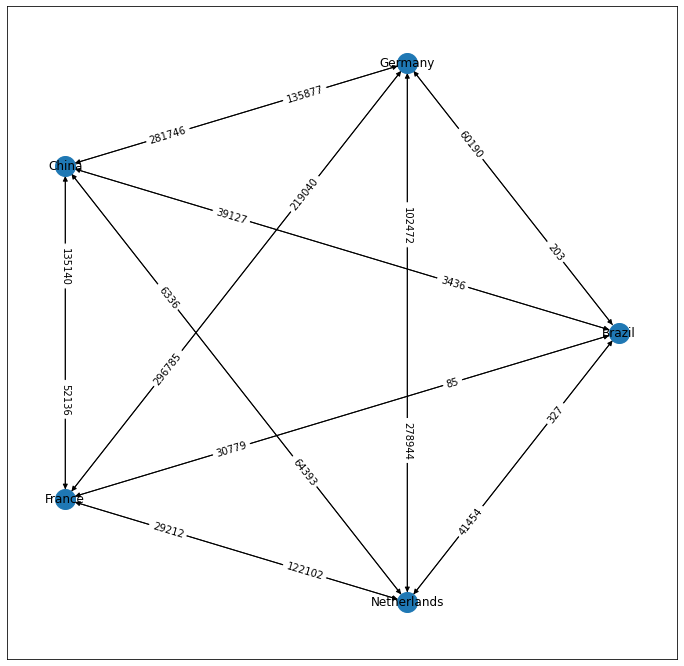

<Figure size 6000x6000 with 0 Axes>

In [95]:
G_2017.vs['label']
nodes_dict = {}
for n in range(len(G_2017.vs['label'])):
    nodes_dict[n] = G_2017.vs['label'][n]

G_2017_nx = G_2017.to_networkx()
labels = nx.get_edge_attributes(G_2017_nx,'weight')
pos = nx.circular_layout(G_2017_nx)
nx.draw_networkx(G_2017_nx, pos, node_size=400, labels=nodes_dict, with_labels=True)
nx.draw_networkx_edge_labels(G_2017_nx, pos, label_pos=0.3, edge_labels=labels)
plt.figure(figsize=(20, 20), dpi=300)
plt.rcParams['figure.figsize'] = [12, 12]

plt.show()

In [10]:
G_2017_nx.nodes()

NodeView((2, 0, 1, 3))

## 2.

We removed also values of partner countries with "Unspecified Area" (probably "Total FAO" got renamed). 

In [11]:
def create_g_top(country_name):
    # get top export partners
    
    all_data = data[["Reporter Countries", "Partner Countries", "Value"]].groupby(["Reporter Countries", "Partner Countries"]).sum().reset_index()
    country_data = all_data[all_data["Reporter Countries"] == country_name]
    
    relevant_countries = country_data.loc[country_data["Value"].nlargest(3).index]["Partner Countries"].tolist()
    relevant_countries.append(country_name)
    country_data
    
    # create relevant dataframe
    relevant_data = all_data[all_data["Reporter Countries"].isin(relevant_countries)]
    relevant_data = relevant_data[relevant_data["Partner Countries"].isin(relevant_countries)]
    
    # use the method from 1. to create a graph
    g_top = create_export_graph(relevant_data)
    
    return g_top
    

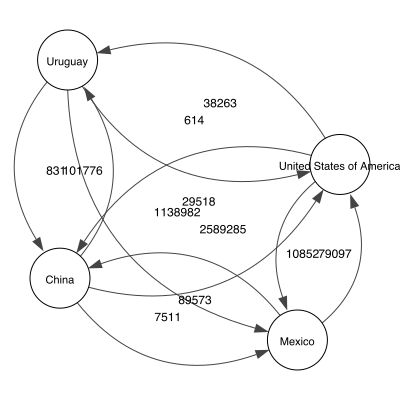

In [12]:
G_top = create_g_top("Uruguay")

visual_style = {}

out_name = "graph_2.png"

visual_style["bbox"] = (600,400)
visual_style["margin"] = 60
visual_style["vertex_color"] = 'white'
visual_style["vertex_size"] = 60
visual_style["vertex_label_size"] = 11
visual_style["edge_curved"] = True
my_layout = G_top.layout_lgl()
visual_style["layout"] = my_layout
plot(G_top, out_name, **visual_style)

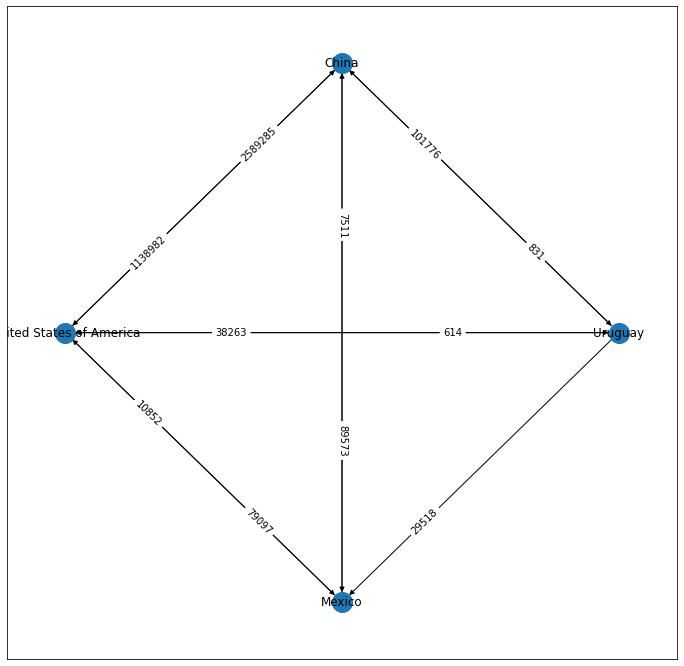

<Figure size 6000x6000 with 0 Axes>

In [88]:
G_top.vs['label']
nodes_dict = {}
for n in range(len(G_top.vs['label'])):
    nodes_dict[n] = G_top.vs['label'][n]

G_top_nx = G_top.to_networkx()
labels = nx.get_edge_attributes(G_top_nx,'weight')
pos = nx.circular_layout(G_top_nx)
nx.draw_networkx(G_top_nx, pos, node_size=400, labels=nodes_dict, with_labels=True)
nx.draw_networkx_edge_labels(G_top_nx, pos, label_pos=0.3, edge_labels=labels)
plt.figure(figsize=(20, 20), dpi=300)
plt.rcParams['figure.figsize'] = [12, 12]

plt.show()

## 3.

In [13]:
def get_country_type(country_name):
    g = create_export_graph(data)
    
    # get node of the country
    country_node = g.vs.find(label=country_name)
    
    # get outgoing edges weights
    out_edges = g.incident(country_node, mode='out')
    
    sum_out_edges = 0
    for e in out_edges:
        sum_out_edges += g.es[e]["weight"]
        
    # get ingoing edges weights
    in_edges = g.incident(country_node, mode='in')
    
    sum_in_edges = 0
    for e in in_edges:
        sum_in_edges += g.es[e]["weight"]
        
    if sum_out_edges > sum_in_edges:
        return f"{country_name} is a net exporter, its export value: {sum_out_edges}"
        
    else:
        return f"{country_name} is a net importer, its import value: {sum_in_edges}"
        
    

In [14]:
get_country_type("Germany")

'Germany is a net importer, its import value: 3785835'